In [2]:
# Importing the necessary libraries and loading the file to df
import pandas as pd 
import numpy as np
%matplotlib inline 
import seaborn as sns
from pmdarima import auto_arima
import warnings
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
df = pd.read_csv('BTC-USD.csv',parse_dates=True,index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-11-01,338.649994,340.528992,321.054993,325.748993,325.748993,16677200.0
2014-11-02,326.075012,329.049988,320.626007,325.891998,325.891998,8603620.0
2014-11-03,325.569000,334.002014,325.480988,327.553986,327.553986,12948500.0
2014-11-04,327.161011,331.766998,325.076996,330.492004,330.492004,15655500.0
2014-11-05,330.683014,343.368988,330.683014,339.485992,339.485992,19817200.0


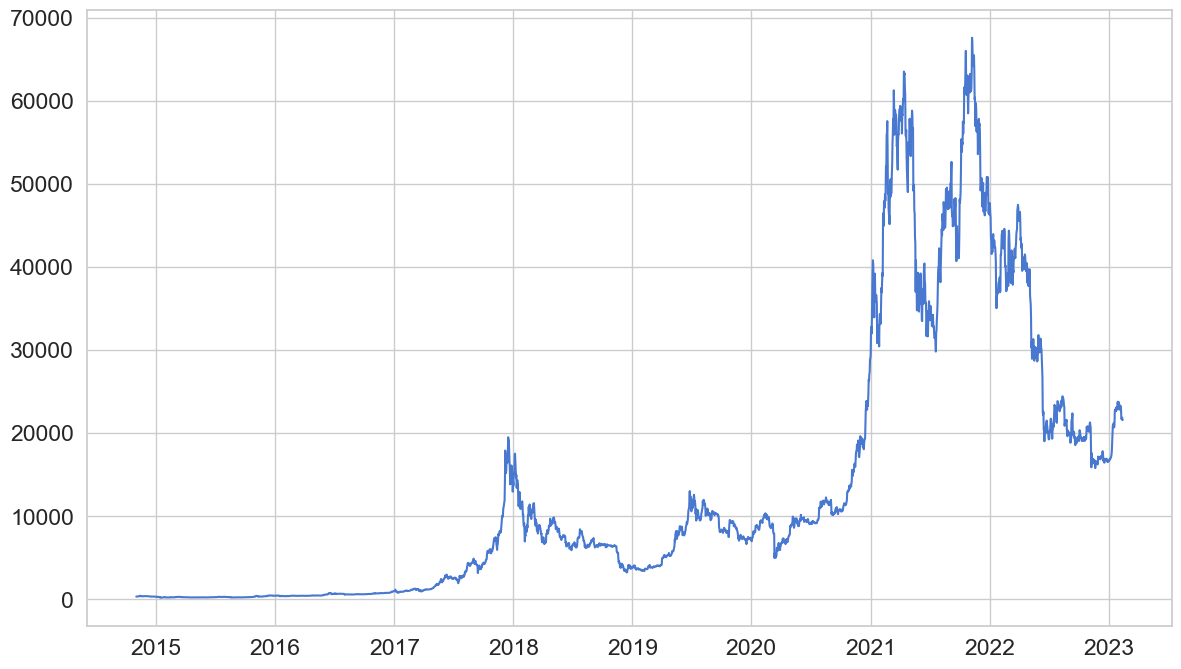

In [3]:
# Plot the Close column from df 
plt.plot(df.index,df['Close'])
plt.show()

In [4]:
# Function that checks if my data is stationery or non-stationery
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [5]:
# Data is stationery. This means in the ARIMA Model, we have to include (-,1,-)
adf_test(df['Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.615979
p-value                    0.474838
# lags used               29.000000
# observations          2997.000000
critical value (1%)       -3.432534
critical value (5%)       -2.862505
critical value (10%)      -2.567284
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [6]:
# 90% for train and 10% for test
ninety_percent_data =int(len(df)*0.90) 
train = df[:ninety_percent_data]['Close'].tolist()
test= df[ninety_percent_data:]['Close'].tolist()

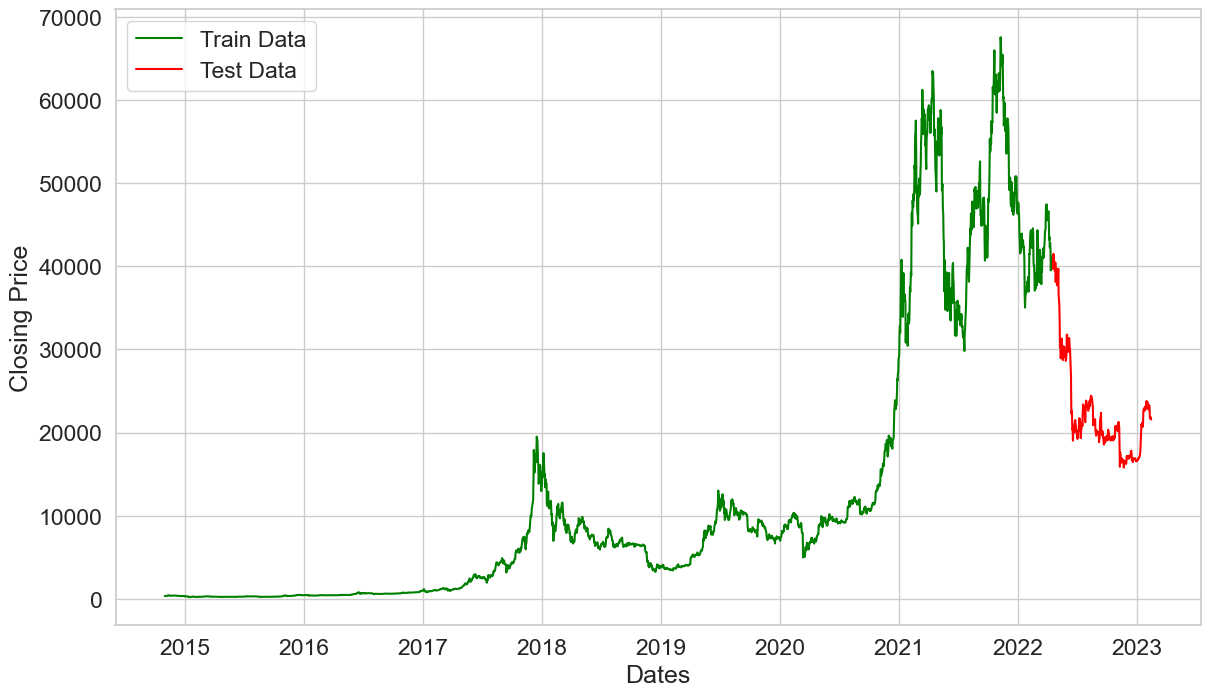

In [7]:
# plot the train and test 
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.plot(df[:ninety_percent_data]['Close'],'green',label='Train Data')
plt.plot(df[ninety_percent_data:]['Close'],'red',label='Test Data')
plt.legend()

In [8]:
# predictions list where we will append the values and observation length to iterate that number of it 
# in the for loop
predictions = []
observation_no = len(test)

In [9]:
# append the predictions and append the real values to the test to plot and compare them
for i in range(observation_no):
    model = ARIMA(train,order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_hat = output[0]
    predictions.append(y_hat)
    actual_test_value = test[i]
    train.append(actual_test_value)

In [10]:
# summary of the ARIMA Model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3026
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -24500.824
Date:                Mon, 20 Feb 2023   AIC                          49011.647
Time:                        08:16:01   BIC                          49041.721
Sample:                             0   HQIC                         49022.460
                               - 3026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0248      0.010     -2.604      0.009      -0.043      -0.006
ar.L2          0.0042      0.009      0.459      0.646      -0.014       0.022
ar.L3          0.0199      0.010      2.037      0.0

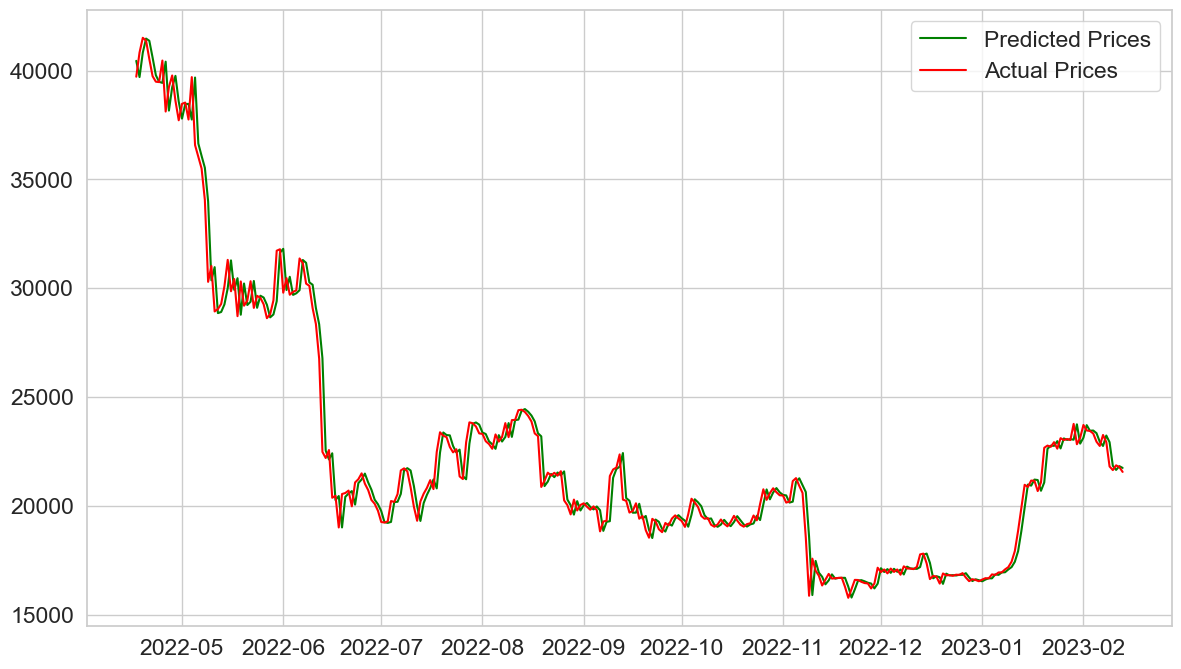

In [11]:
# plot the actual prices against the predicted prices
data_range = df[ninety_percent_data:].index
plt.plot(data_range,predictions,color='green',label='Predicted Prices')
plt.plot(data_range,test,color='red',label='Actual Prices')
plt.legend()

In [12]:
# How well is the model ? 
mean_absolute_percentage_error = np.mean(np.abs(np.array(predictions)-np.array(test))/np.abs(test))
print('MAPE:' +str(mean_absolute_percentage_error*100))

MAPE:2.1497594544691396


In [22]:
# wrong by 60 usd only ! 
mean_actual_price = sum(test) / len(test)
mean_predicted_price = sum(predictions) / len(predictions)
mean_predicted_price - mean_actual_price

60.63798428844893